Needs a few dependencies, at minimum do:

pip install lxml geopandas pycountry fsspec scipy

In [2]:
import pandas as pd

In [3]:
# Switched to country names instead of country codes as these seem more standardized.



country_names = pd.read_csv('wiki_country_names.csv', header = None, index_col = 0).squeeze("columns")
country_names

0
NaN         Team (IOC code)
0.0          American Samoa
1.0                 Andorra
2.0                  Angola
3.0     Antigua and Barbuda
               ...         
66.0           North Borneo
67.0      Republic of China
68.0                   Saar
69.0            North Yemen
70.0            South Yemen
Name: 1, Length: 72, dtype: object

In [4]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load the shapefile from a local path
world = gpd.read_file('110m_cultural.zip')


/opt/homebrew/lib/python3.11/site-packages/pyogrio/geopandas.py:261: UserWarning: More than one layer found in '110m_cultural.zip': 'ne_110m_admin_0_countries' (default), 'ne_110m_admin_0_countries_lakes', 'ne_110m_populated_places', 'ne_110m_admin_1_states_provinces_lakes', 'ne_110m_admin_0_scale_rank', 'ne_110m_admin_1_states_provinces_lines', 'ne_110m_admin_0_boundary_lines_land', 'ne_110m_populated_places_simple', 'ne_110m_admin_0_pacific_groupings', 'ne_110m_admin_0_map_units', 'ne_110m_admin_1_states_provinces', 'ne_110m_admin_0_sovereignty', 'ne_110m_admin_1_states_provinces_scale_rank', 'ne_110m_admin_0_tiny_countries'. Specify layer parameter to avoid this warning.
  result = read_func(


In [5]:
print(world)

          featurecla  scalerank  LABELRANK                   SOVEREIGNT  \
0    Admin-0 country          1          6                         Fiji   
1    Admin-0 country          1          3  United Republic of Tanzania   
2    Admin-0 country          1          7               Western Sahara   
3    Admin-0 country          1          2                       Canada   
4    Admin-0 country          1          2     United States of America   
..               ...        ...        ...                          ...   
172  Admin-0 country          1          5           Republic of Serbia   
173  Admin-0 country          1          6                   Montenegro   
174  Admin-0 country          1          6                       Kosovo   
175  Admin-0 country          1          5          Trinidad and Tobago   
176  Admin-0 country          1          3                  South Sudan   

    SOV_A3  ADM0_DIF  LEVEL               TYPE TLC  \
0      FJI         0      2  Sovereign countr

In [6]:
# Did Myanmar, Nepal, Madagascar, Belize, Chad, Republic of the Congo
print(world.sort_values("SOVEREIGNT").to_string())

          featurecla  scalerank  LABELRANK                        SOVEREIGNT SOV_A3  ADM0_DIF  LEVEL               TYPE   TLC                                ADMIN ADM0_A3  GEOU_DIF                              GEOUNIT GU_A3  SU_DIF                              SUBUNIT SU_A3  BRK_DIFF                      NAME                            NAME_LONG BRK_A3                          BRK_NAME BRK_GROUP      ABBREV POSTAL                                             FORMAL_EN                           FORMAL_FR                         NAME_CIAWF    NOTE_ADM0                                    NOTE_BRK                            NAME_SORT        NAME_ALT  MAPCOLOR7  MAPCOLOR8  MAPCOLOR9  MAPCOLOR13       POP_EST  POP_RANK  POP_YEAR    GDP_MD  GDP_YEAR                     ECONOMY               INCOME_GRP FIPS_10 ISO_A2 ISO_A2_EH ISO_A3 ISO_A3_EH ISO_N3 ISO_N3_EH UN_A3 WB_A2 WB_A3    WOE_ID  WOE_ID_EH                                                                                                  

<Axes: >

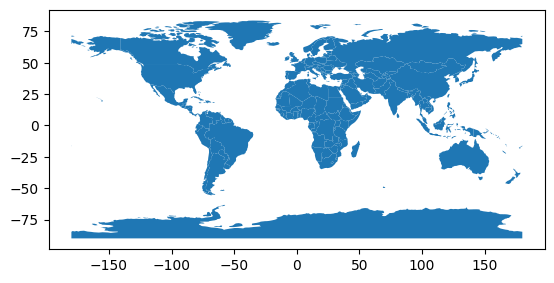

In [7]:
world.plot()

ModuleNotFoundError: No module named 'scipy'

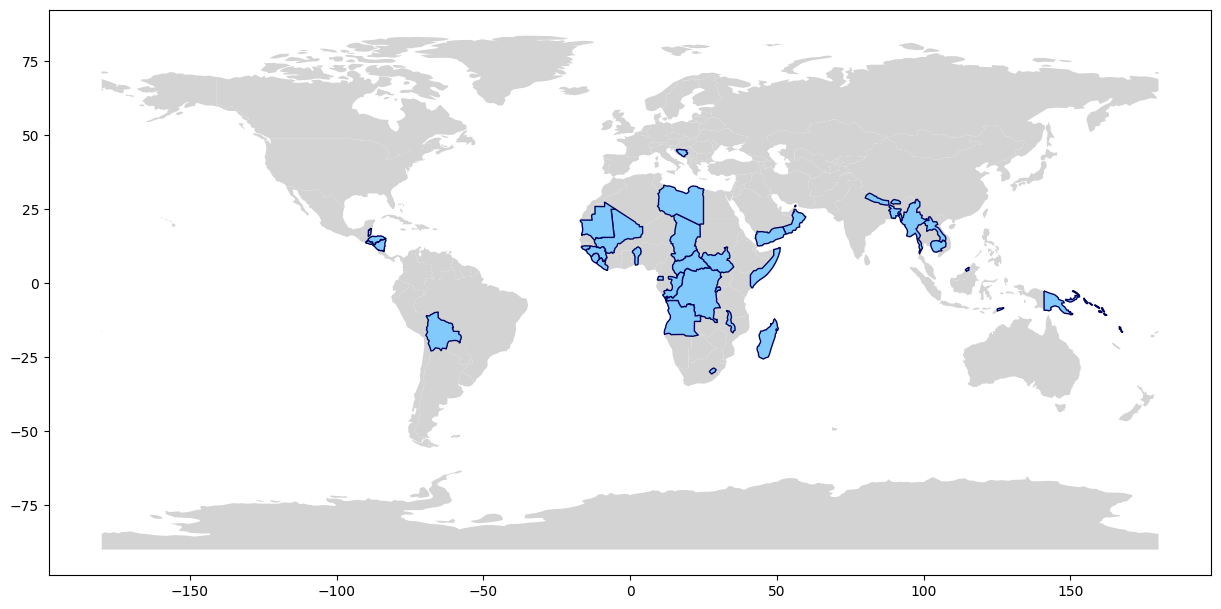

In [67]:
# Filter countries with no medals
no_medals_df = world[world['SOVEREIGNT'].isin(country_names)]

# Plot the map
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world.plot(ax=ax, color='lightgrey')
no_medals_df.plot(ax=ax, color='xkcd:sky', edgecolor='xkcd:dark blue')



import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix

# Function to apply dynamic offsets to the label positions based on proximity
def annotate_with_cluster_offset(df, ax):
    # Get all centroids
    centroids = np.array([geom.centroid.coords[0] for geom in df.geometry])
    
    # Compute the distance matrix between all centroids
    dist_matrix = distance_matrix(centroids, centroids)
    
    # Threshold for proximity (you can tweak this based on the map scale)
    proximity_threshold = 5.0

    # Iterate over each row to adjust label positions
    for idx, row in df.iterrows():
        # Get the centroid of the current country
        centroid = row.geometry.centroid.coords[0]

        # Find nearby centroids within the proximity threshold
        nearby_idx = np.where(dist_matrix[idx] < proximity_threshold)[0]

        # If there are nearby countries, apply a larger offset to spread them out
        if len(nearby_idx) > 1:
            # Define base and random offsets
            base_offset = 3  # Larger offset for clustering
            rand_offset = np.random.uniform(1, 3)

            # Adjust direction randomly to spread them apart
            offset_x = base_offset * rand_offset * np.random.choice([-1, 1])
            offset_y = base_offset * rand_offset * np.random.choice([-1, 1])
        else:
            # Apply a smaller offset for non-clustered areas
            offset_x = np.random.uniform(-1, 1)
            offset_y = np.random.uniform(-1, 1)

        # Calculate the new label position
        label_position = (centroid[0] + offset_x, centroid[1] + offset_y)

        # Annotate the map with the label at the offset position
        ax.annotate(text=row['ADMIN'], xy=label_position, ha='center')

        # Draw a leader line from the label to the centroid
        plt.plot([centroid[0], label_position[0]], [centroid[1], label_position[1]], color='black', lw=0.5)

# Apply the function to the DataFrame
annotate_with_cluster_offset(no_medals_df, ax)







# no_medals_df.apply(lambda x: ax.annotate(text=x['ADMIN'], xy=x.geometry.centroid.coords[0], ha='center'), axis=1)

plt.title('Countries with No Olympic Medals')
plt.show()

In [53]:
type(ax)

matplotlib.axes._axes.Axes

In [10]:
type(no_medals_df)

geopandas.geodataframe.GeoDataFrame